In [1]:
import pandas as pd

papers = pd.read_csv("papers.csv")
papers.drop(['id', 'event_type', 'pdf_name'], axis=1, inplace=True)

In [2]:
import re
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer

stop_words = set(stopwords.words('english'))
##Creating a list of custom stopwords
new_words = ["fig","figure","image","sample","using", 
             "show", "result", "large", 
             "also", "one", "two", "three", 
             "four", "five", "seven","eight","nine"]
stop_words = list(stop_words.union(new_words))

def pre_process(text):
    
    # lowercase
    text=text.lower()
    
    #remove tags
    text=re.sub("&lt;/?.*?&gt;"," &lt;&gt; ",text)
    
    # remove special characters and digits
    text=re.sub("(\\d|\\W)+"," ",text)
    
    ##Convert to list from string
    text = text.split()
    
    # remove stopwords
    text = [word for word in text if word not in stop_words]

    # remove words less than three letters
    text = [word for word in text if len(word) >= 3]

    # lemmatize
    lmtzr = WordNetLemmatizer()
    text = [lmtzr.lemmatize(word) for word in text]
    
    return ' '.join(text)


In [3]:
papers['paper_text'] = papers['paper_text'].apply(pre_process)

In [4]:
import gensim.downloader as api

model = api.load('word2vec-google-news-300')

[==================================================] 100.0% 1662.8/1662.8MB downloaded


In [19]:
import pke
import string

def extract_keyword_from_text(text, n=5):
    # define the set of valid Part-of-Speeches
    pos = {'NOUN', 'PROPN', 'ADJ'}

    # 1. create a SingleRank extractor.
    extractor = pke.unsupervised.TopicRank()

    # 2. load the content of the document.
    stoplist = list(string.punctuation)
    stoplist += ['-lrb-', '-rrb-', '-lcb-', '-rcb-', '-lsb-', '-rsb-']
    stoplist += stopwords.words('english')
    extractor.load_document(input=text,
                            language='en',
                            stoplist=stoplist,
                            normalization=None)

    # 3. select the longest sequences of nouns and adjectives, that do
    #    not contain punctuation marks or stopwords as candidates.
    extractor.candidate_selection(pos=pos)


    # 4. weight the candidates using the sum of their word's scores that are
    #    computed using random walk. In the graph, nodes are words of
    #    certain part-of-speech (nouns and adjectives) that are connected if
    #    they occur in a window of 10 words.
    extractor.candidate_weighting(threshold=0.74, method='average')

    # 5. get the 10-highest scored candidates as keyphrases
    temp = extractor.get_n_best(n=n)
    return [w for w,_ in temp]

In [ ]:
#Use this block to generate the file. It may take a while
import numpy as np
import pickle as pkl
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

periods = [1992+i*5 for i in range(5)]
for period in periods:
    papers_period = papers[(papers['year'] >= period) & (papers['year'] < period+5)]
    N = 100
    papers_period = papers_period.iloc[:N]
    wmd_sim = np.zeros((N, N))
    for i, row_i in tqdm(enumerate(papers_period.iterrows())):
        for j, row_j in enumerate(papers_period.iterrows()):
            wmd_sim[i][j] = model.wmdistance(''.join(extract_keyword_from_text(row_i[1]["paper_text"])),''.join(extract_keyword_from_text(row_j[1]["paper_text"])))
    with open(f"wrd_sim_{period}.pkl", 'wb') as f:
        pkl.dump(wmd_sim, f)

In [96]:
import numpy as np
import pickle as pkl
YEAR = 1987
with open(f'wrd_sim_{YEAR}.pkl', 'rb') as f:
    wrd_sim_1987 = pkl.load(f)

In [102]:
papers_period = papers[(papers['year'] >= YEAR) & (papers['year'] < YEAR+5)]
# cross_papers_1987 = papers_period.iloc[:100].merge(papers.iloc[:100], how='cross')[['title_x', 'title_y']]
# cross_papers_1987['distance'] =  wrd_sim_1987.flatten().tolist()

In [114]:
from sklearn.manifold import MDS
mds = MDS(random_state=0, metric=False, n_components=200, dissimilarity='precomputed')
mat_transform = mds.fit_transform(wrd_sim_1987)


c:\Users\gerry\miniconda3\envs\torch\lib\site-packages\sklearn\manifold\_mds.py:299: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


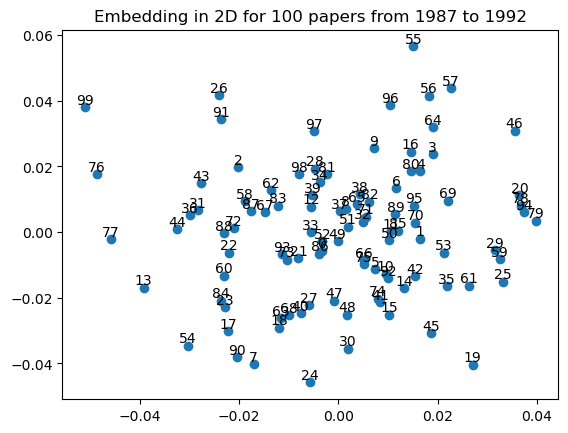

In [115]:
import matplotlib.pyplot as plt

plt.scatter(mat_transform[:,0], mat_transform[:,1])
for i in range(100):
    plt.text(mat_transform[i,0], mat_transform[i,1], i, va='bottom', ha='center')
plt.title(f'Embedding in 2D for 100 papers from 1987 to 1992')
plt.show()

In [110]:
IDX = 83
print(papers_period.iloc[IDX].title)
print(extract_keyword_from_text(papers_period.iloc[IDX].paper_text))

Fast Learning in Multi-Resolution Hierarchies
['multi resolution hierarchy', 'function', 'input space', 'propagation', 'real time']


In [106]:
IDX = 46
print(papers_period.iloc[IDX].title)
print(extract_keyword_from_text(papers_period.iloc[IDX].paper_text))

Speech Production Using A Neural Network with a Cooperative Learning Mechanism
['output layer multiple', 'system', 'sicl method', 'neural network', 'convergence rate spread pattern information']


In [107]:
IDX = 48
print(papers_period.iloc[IDX].title)
print(extract_keyword_from_text(papers_period.iloc[IDX].paper_text))

Temporal Representations in a Connectionist Speech System
['individual node', 'delay line filter', 'input buffer', 'respond transition', 'data']


In [109]:
IDX = 68
print(papers_period.iloc[IDX].title)
print(extract_keyword_from_text(papers_period.iloc[IDX].paper_text))

Neural Approach for TV Image Compression Using a Hopfield Type Network
['net attractor', 'codebook vector', 'training', 'tastable state', 'vector pixel']


In [113]:
IDX = 57
print(papers_period.iloc[IDX].title)
print(extract_keyword_from_text(papers_period.iloc[IDX].paper_text))

Winner-Take-All Networks of O(N) Complexity
['circuit', 'winner', 'neuron', 'unidirectional current input output voltage', 'common wire transistor']


In [112]:
IDX = 56
print(papers_period.iloc[IDX].title)
print(extract_keyword_from_text(papers_period.iloc[IDX].paper_text))

An Information Theoretic Approach to Rule-Based Connectionist Expert Systems
['rule', 'data set', 'information event', 'range unit input layer', 'measure state node']
